In [91]:
%cd F:\\working-directory\UQ_Python\
    
%load_ext autoreload

import scipy as sp
import numpy as np
from sklearn.datasets import make_moons
from datasets.Graph_manager import Graph_manager
import matplotlib.pyplot as plt
import random

F:\working-directory\UQ_Python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
%autoreload 2

Compute eigs from scratch


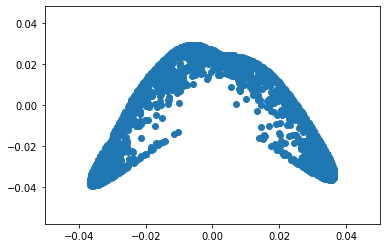

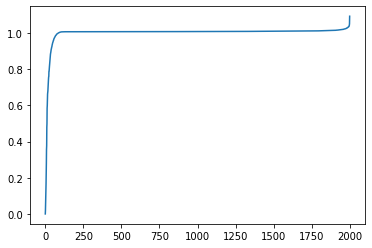

In [155]:
N = 2000
gamma2 = 0.0001
alpha  = 1.0
tau    = 0.1

X, labels = make_moons(N, noise=0.16)
gm = Graph_manager()
graph_params = {
    'knn'    : None,
    'sigma'  : 0.1,
    'Ltype'  : 'normed',
    'n_eigs' : N,
    'zp_k'   : None,
}
X = np.vstack(( X[labels == 1, :], X[labels == 0, :]))
w, v = gm.from_features(X, graph_params, debug=True)
plt.scatter(v[:,1], v[:,2])
plt.show()
plt.plot(w)
d = (tau ** (2. * alpha)) * ((w + tau**2.) ** (-alpha))
C = v @ sp.sparse.diags(d, format='csr') @ v.T
C_inv = v @ sp.sparse.diags(1./d, format='csr') @ v.T

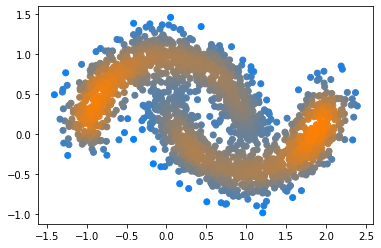

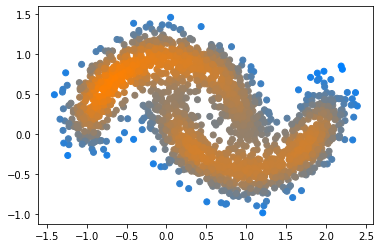

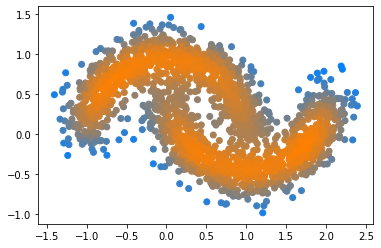

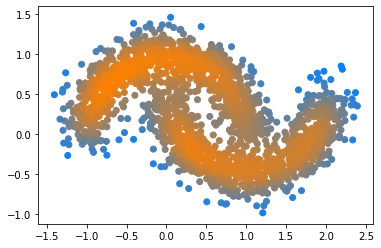

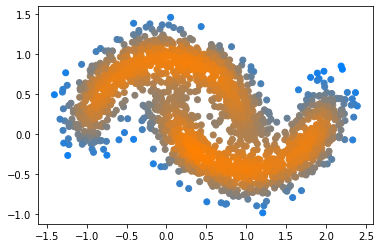

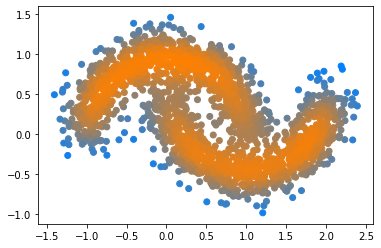

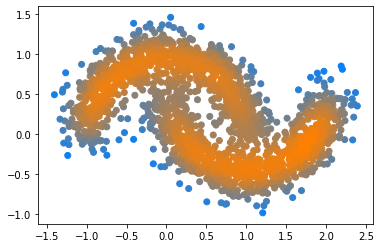

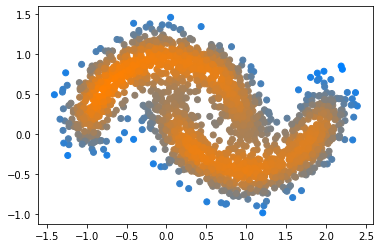

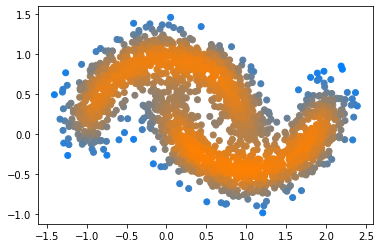

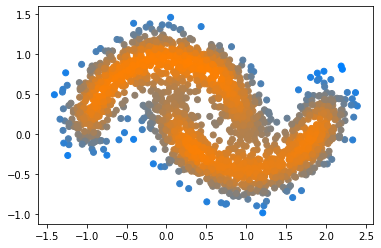

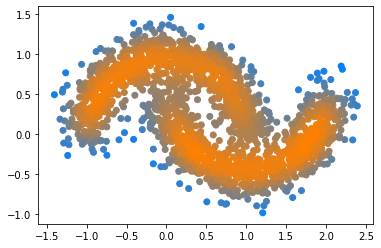

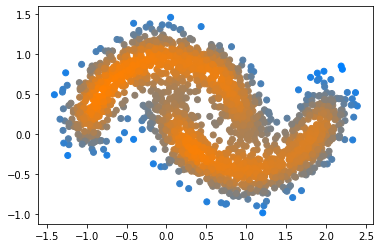

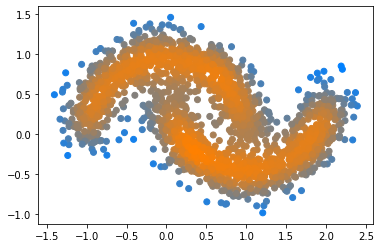

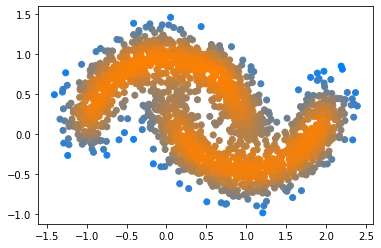

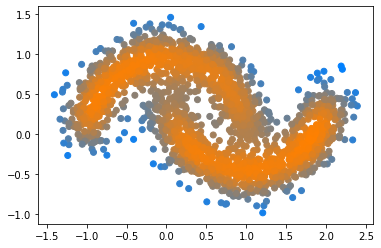

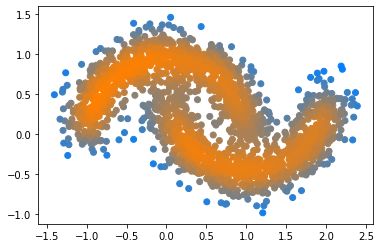

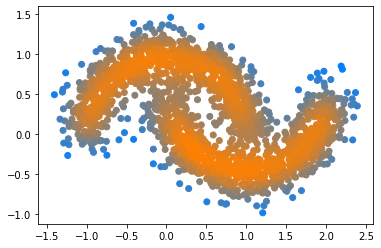

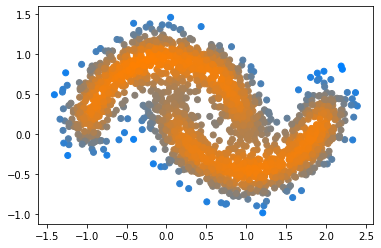

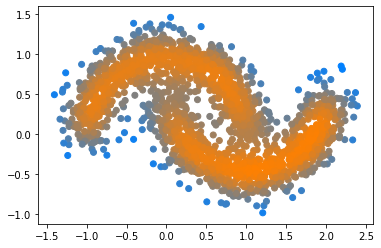

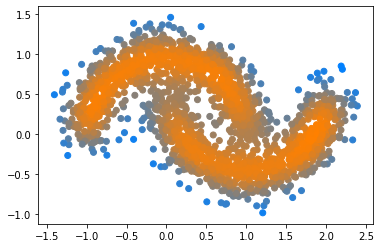

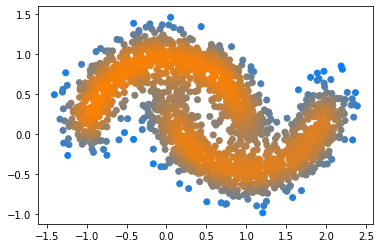

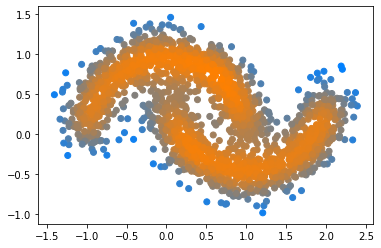

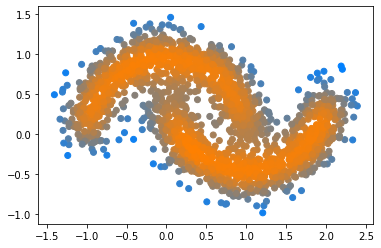

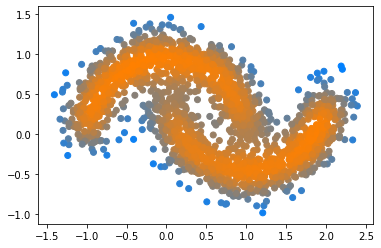

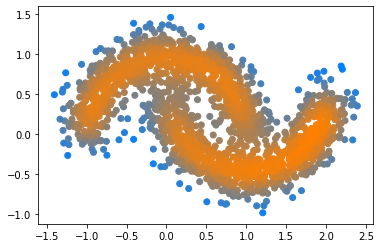

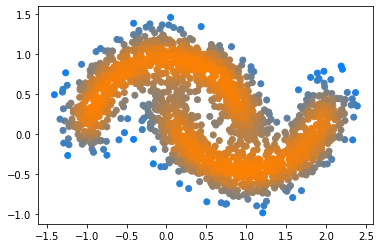

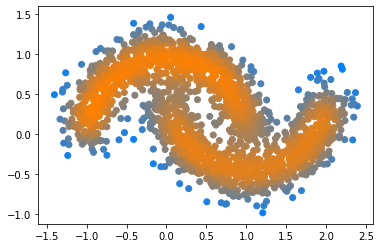

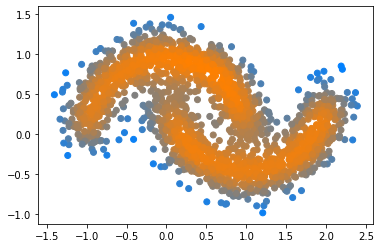

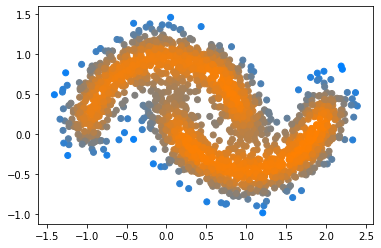

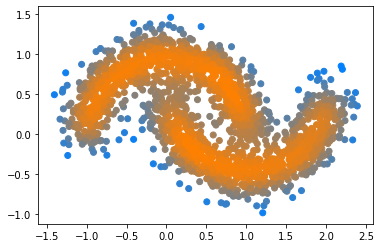

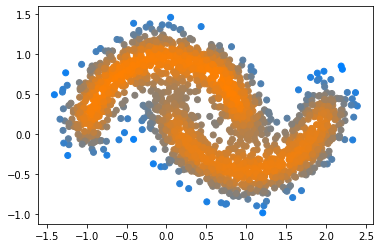

[289, 1309, 615, 1353, 718, 1038, 216, 1168, 900, 1922, 70, 1526, 910, 1819, 50, 1968, 988, 1971, 252, 572, 1273, 1998, 384, 1220, 459, 116, 1425, 1018, 296, 973, 1419]


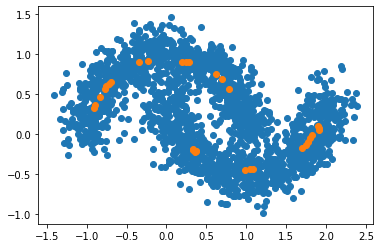

In [156]:
def v_risk(C_inv, labeled, gamma2):
    """
    calculate the risk of each unlabeled point
    """
    N = C_inv.shape[0]
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    B_diag = [1 if i in labeled else 0 for i in range(N)]
    B = sp.sparse.diags(B_diag, format='csr')
    C = sp.linalg.inv(C_inv + B/gamma2)
    return np.sum(C.diagonal()[unlabeled]), C

def V_opt(C, unlabeled, gamma2):
    ips = np.array([np.inner(C[k,:], C[k,:]) for k in unlabeled]).flatten()
    v_opt = ips/(gamma2 + np.diag(C)[unlabeled])
    
    v_opt = (v_opt - min(v_opt))/(max(v_opt) - min(v_opt))
    colors = [(x, 0.5,(1-x)) for x in v_opt]
    plt.scatter(X[unlabeled, 0],X[unlabeled,1], c=colors)
    plt.show()
    
    k_max = unlabeled[np.argmax(v_opt)]
    return k_max

def Sigma_opt(C, unlabeled, gamma2):
    sums = np.sum(C[np.ix_(unlabeled,unlabeled)], axis=1)
    sums = np.asarray(sums).flatten()**2.
    s_opt = sums/(gamma2 + np.diag(C)[unlabeled])
    k_max = unlabeled[np.argmax(s_opt)]
    return k_max

# C = prior covariance
C = v @ sp.sparse.diags(d, format='csr') @ v.T
v_opt = C.diagonal()
v_opt = (v_opt - min(v_opt))/(max(v_opt) - min(v_opt))
colors = [(x, 0.5,(1-x)) for x in v_opt]
plt.scatter(X[:, 0],X[:,1], c=colors)
plt.show()
    
labeled = [np.argmax(C.diagonal())]
# C = posterior covariance with one labeled point
_, C = v_risk(C_inv, labeled, gamma2)
for i in range(30):
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    k = V_opt(C, unlabeled, gamma2)
    labeled += [k]
    ck = C[k,:]
    ckk = ck[k]
    C -= (1./(gamma2 + ckk)) * np.outer(ck,ck)

plt.scatter(X[:, 0],X[:, 1])
plt.scatter(X[labeled, 0], X[labeled, 1])
print(labeled)